# Exploratory Data Analysis (EDA)

Este notebook realiza el análisis exploratorio del dataset de ventas con los siguientes objetivos:

1. Identificar las tiendas con mayor volumen de ventas.
2. Seleccionar una tienda representativa (Tienda 47).
3. Filtrar productos con alta cobertura temporal y baja variabilidad.
4. Analizar la distribución y comportamiento temporal de las series.
5. Evaluar el efecto de una transformación logarítmica.

El análisis servirá como base para la posterior modelización con LSTM, CNN y TCN y optimización mediante BO, RS, GA y PSO.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")



### 1. Análisis de tiendas con mayor volumen de ventas

Se analiza el dataset completo para identificar las tiendas con mayor volumen total de ventas.


In [2]:
print("Leyendo train.csv (esto puede tardar)...")
chunks = []
chunk_size = 100000

for chunk in pd.read_csv('../data/raw/train.csv', parse_dates=["date"], chunksize=chunk_size):
    chunks.append(chunk)
    print(f'  Procesados {len(chunks) * chunk_size:,} filas...', end='\r')

df_completo = pd.concat(chunks, ignore_index=True)
print(f'\nDataset completo cargado: {len(df_completo):,} filas')


Leyendo train.csv (esto puede tardar)...
  Procesados 125,500,000 filas...
Dataset completo cargado: 125,497,040 filas


In [3]:
store_stats = (
    df_completo
    .groupby('store_nbr')
    .agg(
        total_sales=('unit_sales', 'sum'),
        num_items=('item_nbr', 'nunique'),
        mean_sales=('unit_sales', 'mean'),
        num_transactions=('unit_sales', 'count')
    )
    .sort_values('total_sales', ascending=False)
    .reset_index()
)

# Guardar estadísticas de tiendas
store_stats.to_excel('../results/metrics/store_stats.xlsx', index=False)
print(f'Estadísticas de tiendas guardadas en /results/metrics/store_stats.xlsx')


store_stats.head()


Estadísticas de tiendas guardadas en /results/metrics/store_stats.xlsx


,store_nbr,total_sales,num_items,mean_sales,num_transactions
0,44,6.208754e+07,3671,17.673206,3513089
1,45,5.449801e+07,3676,15.641273,3484244
2,47,5.094831e+07,3680,14.735988,3457407
3,3,5.048190e+07,3671,14.842100,3401264
4,49,4.342009e+07,3663,12.990183,3342531


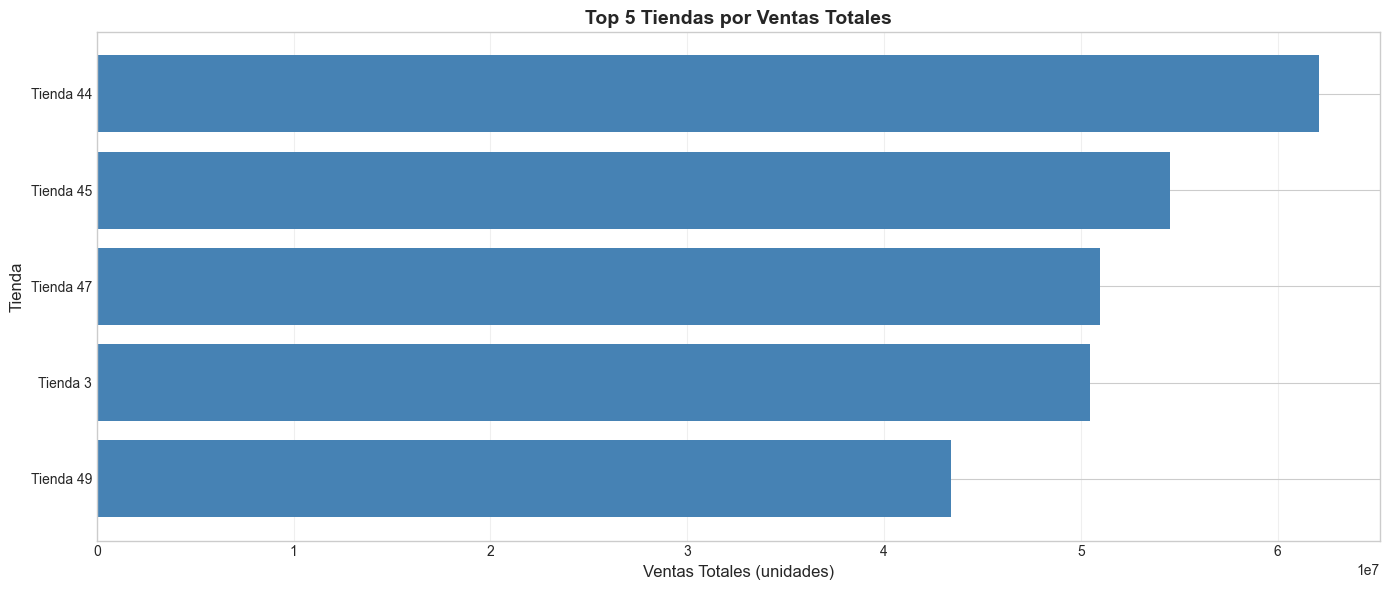

Gráfico guardado: /results/figures/grafico_01_top_tiendas_ventas.png


In [4]:
# Gráfico 1: Top 5 tiendas por ventas totales
plt.figure(figsize=(14, 6))
top_stores = store_stats.head(5)

plt.barh(range(len(top_stores)), top_stores['total_sales'], color='steelblue')
plt.yticks(range(len(top_stores)), [f'Tienda {s}' for s in top_stores['store_nbr']])
plt.xlabel('Ventas Totales (unidades)', fontsize=12)
plt.ylabel('Tienda', fontsize=12)
plt.title('Top 5 Tiendas por Ventas Totales', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/grafico_01_top_tiendas_ventas.png', dpi=300, bbox_inches='tight')
plt.show()
print('Gráfico guardado: /results/figures/grafico_01_top_tiendas_ventas.png')


### 2. Cargamos series_tienda_47.csv

Cargamos el archivo previamente creado con los datos de la tienda 47 filtrando desde train.csv.


In [5]:
#cargamos el dataset de la tienda 47 que hemos guardado previamente
series_df = pd.read_csv('../data/processed/series_tienda_47.csv', parse_dates=["date"])

print(f'Filas: {len(series_df):,}')
print(f'Rango fechas: {series_df["date"].min()} - {series_df["date"].max()}')
print(f'Productos únicos: {series_df["item_nbr"].nunique()}')


C:\Users\jesus\AppData\Local\Temp\ipykernel_19856\849882852.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  series_df = pd.read_csv('../data/processed/series_tienda_47.csv', parse_dates=["date"])


Filas: 3,457,407
Rango fechas: 2013-01-02 00:00:00 - 2017-08-15 00:00:00
Productos únicos: 3680


In [6]:
print('Analizando productos...')
product_range = (
    series_df
    .groupby('item_nbr')
    .agg(
        first_date=('date', 'min'),
        last_date=('date', 'max'),
        mean_sales=('unit_sales', 'mean'),
        std_sales=('unit_sales', 'std'),
        coef_var_sales=('unit_sales', lambda x: x.std() / x.mean() if x.mean() != 0 else 0),
        num_days=('date', 'nunique'),
        total_sales=('unit_sales', 'sum')
    )
    .reset_index()
)

product_range['total_possible_days'] = (
    (product_range['last_date'] - product_range['first_date']).dt.days + 1
)

product_range.head()


Analizando productos...


,item_nbr,first_date,last_date,mean_sales,std_sales,coef_var_sales,num_days,total_sales,total_possible_days
0,96995,2013-01-09,2017-08-14,2.154321,2.068699,0.960256,324,698.0,1679
1,99197,2014-08-19,2017-08-02,1.934884,1.392719,0.719795,215,416.0,1080
2,103520,2013-01-03,2017-08-15,7.253388,5.822530,0.802732,1476,10706.0,1686
3,103665,2013-01-02,2017-08-15,5.540373,3.877224,0.699813,1610,8920.0,1687
4,105574,2013-01-02,2017-08-15,18.478762,13.959897,0.755456,1648,30453.0,1687


In [7]:
max_days = product_range['num_days'].max()
days_threshold = max_days * 0.96

last_date_dataset = series_df['date'].max()
last_week_cutoff = last_date_dataset - pd.Timedelta(days=7)

filters = (product_range['num_days'] > days_threshold) & (product_range['last_date'] >= last_week_cutoff)
product_range['coverage'] = product_range['num_days'] / product_range['total_possible_days']
product_range = product_range[product_range['coverage'] >= 0.8].sort_values(by='coef_var_sales', ascending=True)
product_range = product_range[filters]

# Guardar estadísticas de productos
product_range.to_excel('../results/metrics/product_range.xlsx', index=False)
print('Estadísticas de productos guardadas en results/metrics/product_range.xlsx')

product_range_list = product_range.iloc[:20]['item_nbr'].tolist()
print(f"Productos seleccionados: {product_range_list}")

series_df_filtered = series_df[series_df['item_nbr'].isin(product_range_list)].copy()
series_df_filtered.to_csv('../data/processed/series_tienda47_seleccionados.csv', index=False)
print(f'Dataset filtrado guardado: {len(series_df_filtered):,} filas')


C:\Users\jesus\AppData\Local\Temp\ipykernel_19856\1184101702.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  product_range = product_range[filters]


Estadísticas de productos guardadas en results/metrics/product_range.xlsx
Productos seleccionados: [584028, 364606, 582863, 368213, 314384, 305229, 1083152, 557256, 852110, 213652, 582864, 129635, 168930, 838216, 502331, 407499, 841197, 557408, 582865, 617096]
Dataset filtrado guardado: 33,467 filas


### 3. Visualización de series temporales

Se muestran tres productos con baja variabilidad (menor coeficiente de variación).


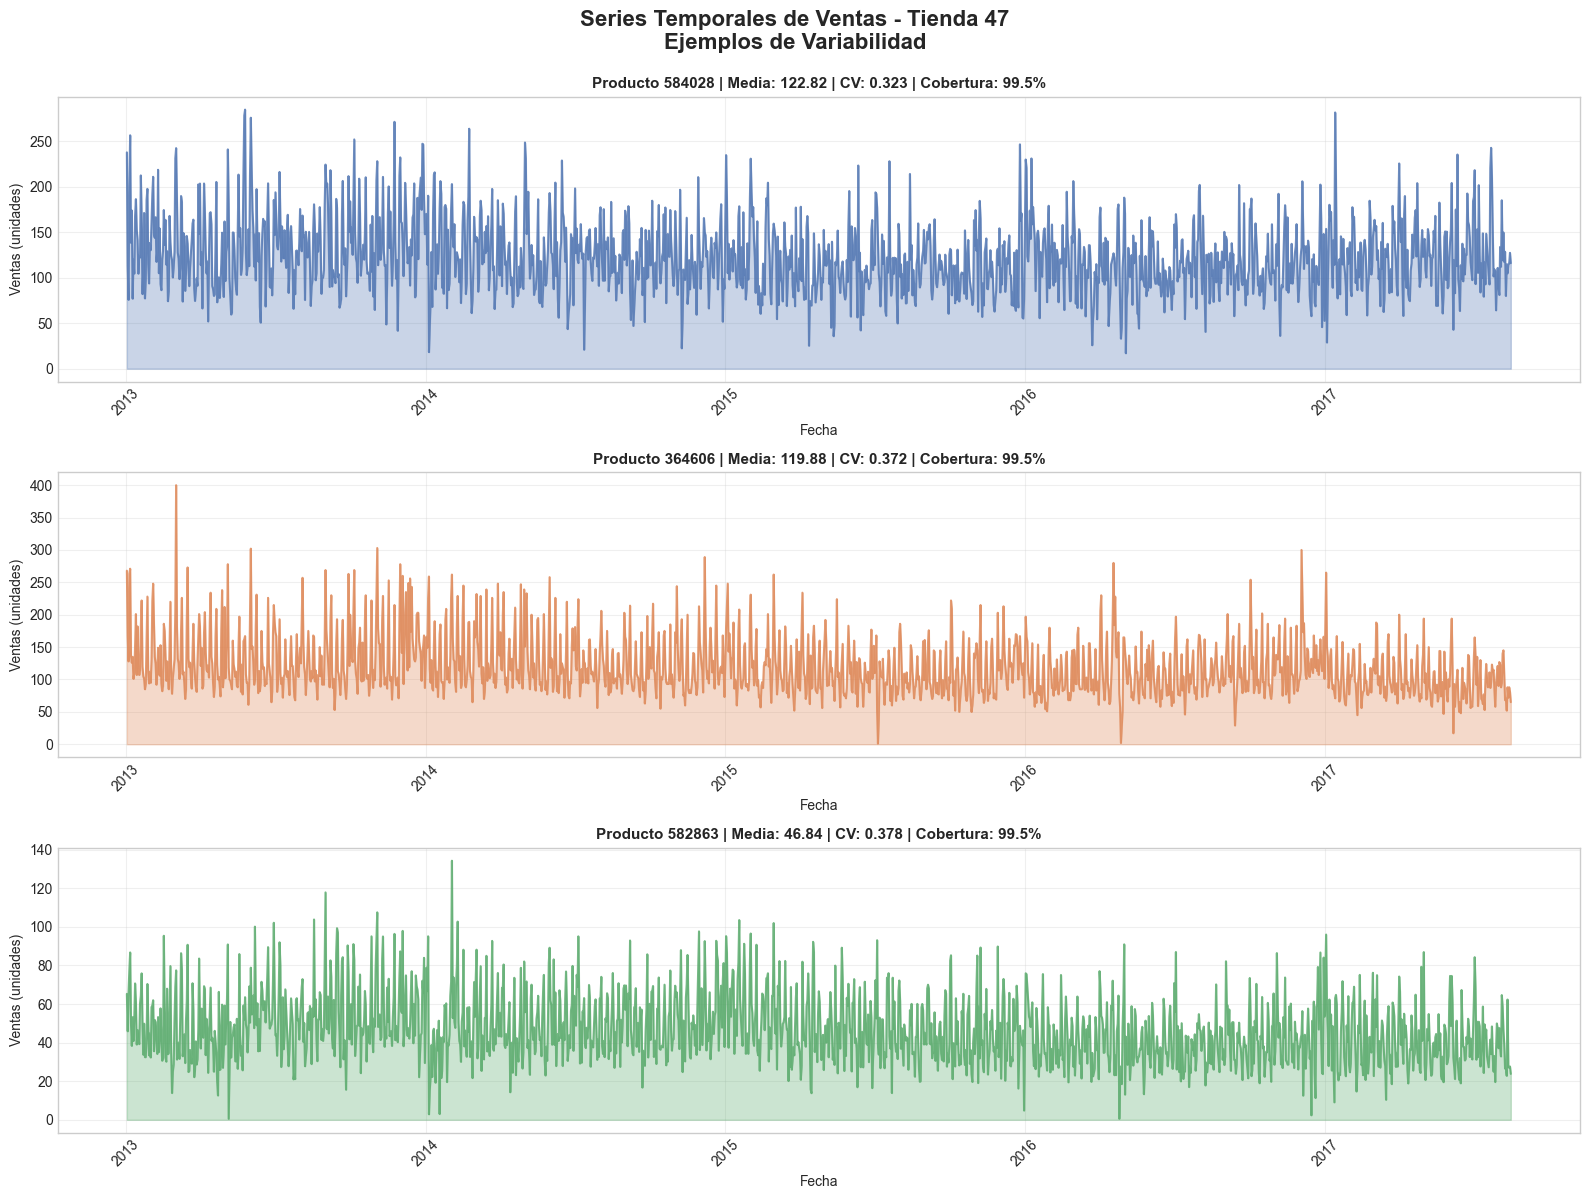

Gráfico guardado: results/figures/grafico_02_series_temporales_3_items.png


In [8]:
productos_ejemplo = product_range_list[:3]

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Series Temporales de Ventas - Tienda 47\nEjemplos de Variabilidad', 
             fontsize=16, fontweight='bold', y=0.995)

for idx, item in enumerate(productos_ejemplo):
    item_data = series_df_filtered[series_df_filtered['item_nbr'] == item].sort_values('date')
    stats = product_range[product_range['item_nbr'] == item].iloc[0]
    
    axes[idx].plot(item_data['date'], item_data['unit_sales'], 
                   linewidth=1.5, alpha=0.8, color=f'C{idx}')
    axes[idx].fill_between(item_data['date'], item_data['unit_sales'], 
                          alpha=0.3, color=f'C{idx}')
    axes[idx].set_title(
        f'Producto {item} | Media: {stats["mean_sales"]:.2f} | '
        f'CV: {stats["coef_var_sales"]:.3f} | Cobertura: {stats["coverage"]:.1%}',
        fontsize=11, fontweight='bold'
    )
    axes[idx].set_xlabel('Fecha', fontsize=10)
    axes[idx].set_ylabel('Ventas (unidades)', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/figures/grafico_02_series_temporales_3_items.png', dpi=300, bbox_inches='tight')
plt.show()
print('Gráfico guardado: results/figures/grafico_02_series_temporales_3_items.png')


### 4. Relación entre Cobertura y Variabilidad

Se analiza la relación entre la cobertura temporal y el coeficiente de variación de los productos.


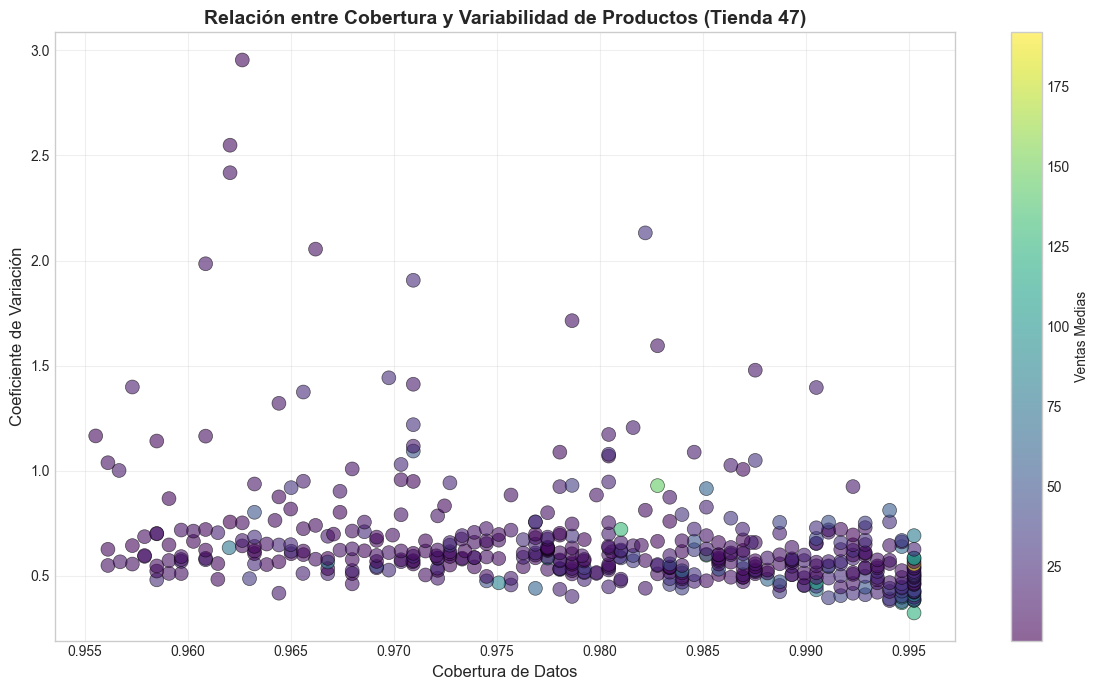

Gráfico guardado: results/figures/grafico_03_cobertura_vs_variabilidad.png


In [9]:
plt.figure(figsize=(12, 7))
scatter = plt.scatter(product_range['coverage'], product_range['coef_var_sales'], 
                     s=100, alpha=0.6, c=product_range['mean_sales'], 
                     cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Ventas Medias')
plt.xlabel('Cobertura de Datos', fontsize=12)
plt.ylabel('Coeficiente de Variación', fontsize=12)
plt.title('Relación entre Cobertura y Variabilidad de Productos (Tienda 47)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/grafico_03_cobertura_vs_variabilidad.png', dpi=300, bbox_inches='tight')
plt.show()
print('Gráfico guardado: results/figures/grafico_03_cobertura_vs_variabilidad.png')


### 5. Distribución de ventas (Boxplot)

Se analiza la distribución de ventas para los 10 productos seleccionados.


C:\Users\jesus\AppData\Local\Temp\ipykernel_19856\3668777945.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_boxplot, labels=labels_boxplot, patch_artist=True)


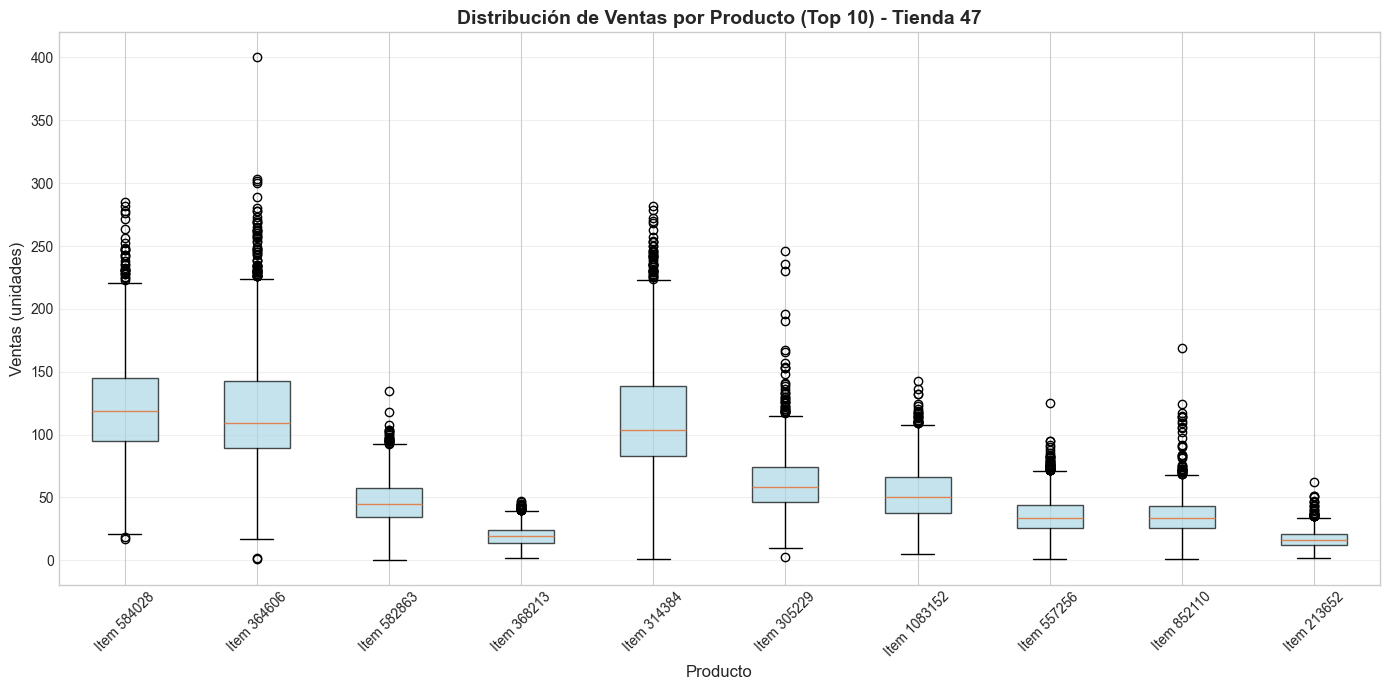

Gráfico guardado: results/figures/grafico_04_boxplot_ventas_productos.png


In [10]:
top_10_items = product_range_list[:10]
data_boxplot = [series_df_filtered[series_df_filtered['item_nbr'] == item]['unit_sales'].values 
                for item in top_10_items]
labels_boxplot = [f'Item {item}' for item in top_10_items]

plt.figure(figsize=(14, 7))
bp = plt.boxplot(data_boxplot, labels=labels_boxplot, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
plt.ylabel('Ventas (unidades)', fontsize=12)
plt.xlabel('Producto', fontsize=12)
plt.title('Distribución de Ventas por Producto (Top 10) - Tienda 47', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/grafico_04_boxplot_ventas_productos.png', dpi=300, bbox_inches='tight')
plt.show()
print('Gráfico guardado: results/figures/grafico_04_boxplot_ventas_productos.png')


### 5. Transformación logarítmica

Se evalúa el efecto de aplicar la transformación:


$$y' = \log(1 + y)$$


para reducir la variabilidad.


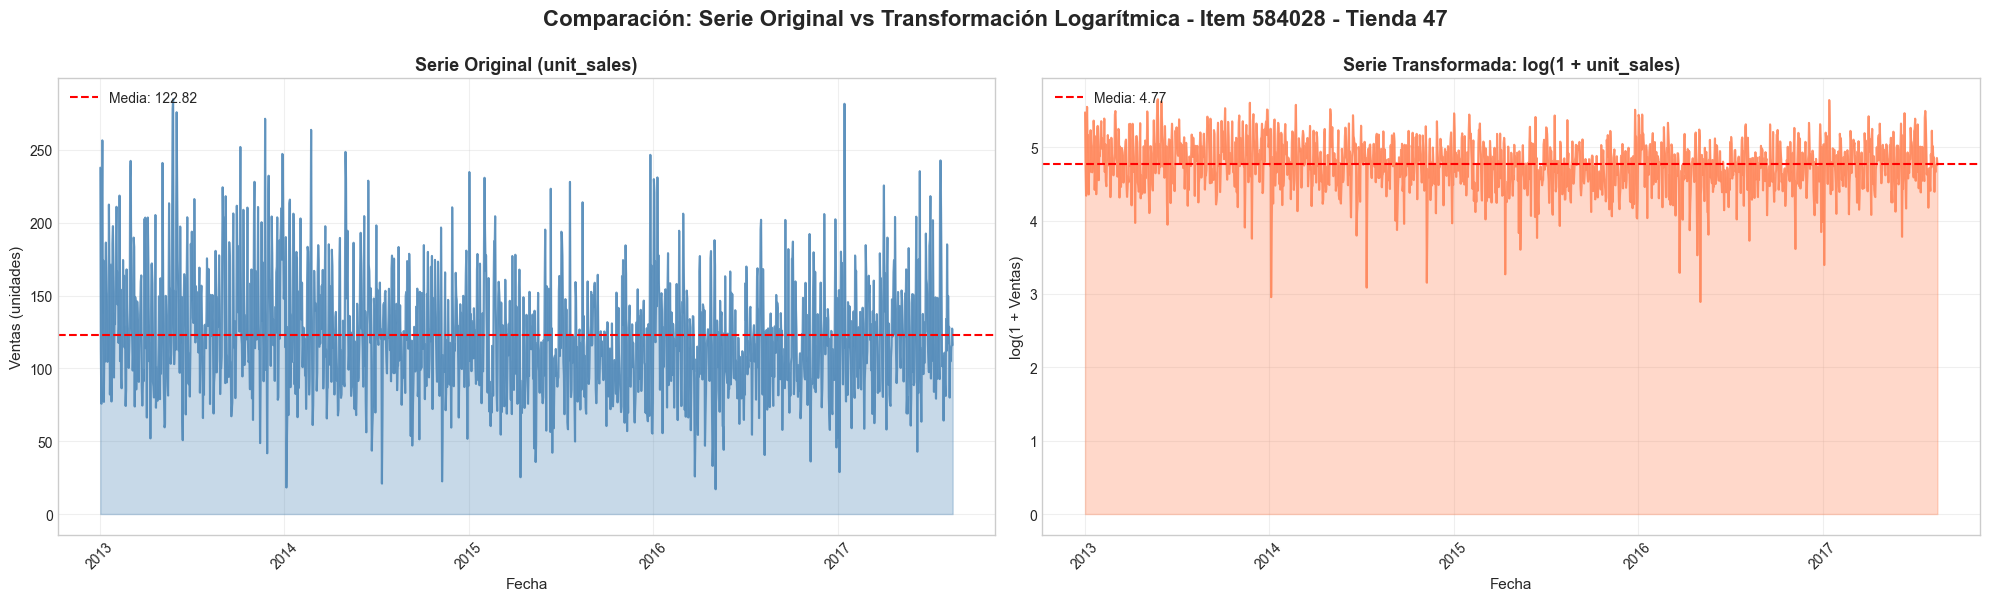

Gráfico guardado: results/figures/grafico_05_transformacion_logaritmica.png
  Item seleccionado: 584028
  Media original: 122.82 | Desviación estándar: 39.73
  Media transformada: 4.77 | Desviación estándar: 0.34
  Reducción de desviación estándar: 99.2%


In [11]:
item_ejemplo = product_range_list[0]
item_data = series_df_filtered[series_df_filtered['item_nbr'] == item_ejemplo].sort_values('date').copy()

# Aplicar transformación logarítmica
item_data['unit_sales_log'] = np.log1p(item_data['unit_sales'])

# Crear gráfico comparativo
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle(f'Comparación: Serie Original vs Transformación Logarítmica - Item {item_ejemplo} - Tienda 47',    
             fontsize=16, fontweight='bold', y=0.995)

# Gráfico 1: Serie original
axes[0].plot(item_data['date'], item_data['unit_sales'], 
             linewidth=1.5, color='steelblue', alpha=0.8)
axes[0].fill_between(item_data['date'], item_data['unit_sales'], 
                     alpha=0.3, color='steelblue')
axes[0].set_title('Serie Original (unit_sales)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Fecha', fontsize=11)
axes[0].set_ylabel('Ventas (unidades)', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Estadísticas originales
mean_orig = item_data['unit_sales'].mean()
std_orig = item_data['unit_sales'].std()
axes[0].axhline(mean_orig, color='red', linestyle='--', linewidth=1.5, 
                label=f'Media: {mean_orig:.2f}')
axes[0].legend(loc='upper left')

# Gráfico 2: Serie transformada
axes[1].plot(item_data['date'], item_data['unit_sales_log'], 
             linewidth=1.5, color='coral', alpha=0.8)
axes[1].fill_between(item_data['date'], item_data['unit_sales_log'], 
                     alpha=0.3, color='coral')
axes[1].set_title('Serie Transformada: log(1 + unit_sales)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=11)
axes[1].set_ylabel('log(1 + Ventas)', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Estadísticas transformadas
mean_log = item_data['unit_sales_log'].mean()
std_log = item_data['unit_sales_log'].std()
axes[1].axhline(mean_log, color='red', linestyle='--', linewidth=1.5, 
                label=f'Media: {mean_log:.2f}')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../results/figures/grafico_05_transformacion_logaritmica.png', dpi=300, bbox_inches='tight')
plt.show()
print('Gráfico guardado: results/figures/grafico_05_transformacion_logaritmica.png')
print(f'  Item seleccionado: {item_ejemplo}')
print(f'  Media original: {mean_orig:.2f} | Desviación estándar: {std_orig:.2f}')
print(f'  Media transformada: {mean_log:.2f} | Desviación estándar: {std_log:.2f}')
print(f'  Reducción de desviación estándar: {((std_orig - std_log) / std_orig * 100):.1f}%')


### 6. Resumen Estadístico Final


In [12]:
print('='*60)
print('RESUMEN ESTADÍSTICO')
print('='*60)
print(f'\nDataset completo:')
print(f'  - Total de filas: {len(df_completo):,}')
print(f'  - Total de tiendas: {df_completo["store_nbr"].nunique()}')
print(f'  - Total de productos: {df_completo["item_nbr"].nunique()}')
print(f'  - Rango de fechas: {df_completo["date"].min()} a {df_completo["date"].max()}')

print(f'\nTienda 47 (antes del filtrado):')
print(f'  - Total de filas: {len(series_df):,}')
print(f'  - Productos únicos: {series_df["item_nbr"].nunique()}')
print(f'  - Ventas totales: {series_df["unit_sales"].sum():,.0f} unidades')
print(f'  - Ventas promedio: {series_df["unit_sales"].mean():.2f} unidades/día')

print(f'\nTienda 47 (después del filtrado - productos seleccionados):')
print(f'  - Total de filas: {len(series_df_filtered):,}')
print(f'  - Productos seleccionados: {len(product_range_list)}')
print(f'  - Ventas totales: {series_df_filtered["unit_sales"].sum():,.0f} unidades')
print(f'  - Ventas promedio: {series_df_filtered["unit_sales"].mean():.2f} unidades/día')
print(f'  - Coeficiente de variación promedio: {product_range["coef_var_sales"].mean():.3f}')
print(f'  - Cobertura promedio: {product_range["coverage"].mean():.1%}')

print('\n' + '='*60)
print('PROCESAMIENTO COMPLETADO')
print('='*60)
print(f'\nTodos los gráficos guardados en: results/figures/')
print(f'Todas las tablas guardadas en: results/metrics/')
print(f'Datos procesados guardados en: data/processed/series_tienda47_seleccionados.csv')


RESUMEN ESTADÍSTICO

Dataset completo:
  - Total de filas: 125,497,040
  - Total de tiendas: 54
  - Total de productos: 4036
  - Rango de fechas: 2013-01-01 00:00:00 a 2017-08-15 00:00:00

Tienda 47 (antes del filtrado):
  - Total de filas: 3,457,407
  - Productos únicos: 3680
  - Ventas totales: 50,948,308 unidades
  - Ventas promedio: 14.74 unidades/día

Tienda 47 (después del filtrado - productos seleccionados):
  - Total de filas: 33,467
  - Productos seleccionados: 20
  - Ventas totales: 1,736,692 unidades
  - Ventas promedio: 51.89 unidades/día
  - Coeficiente de variación promedio: 0.655
  - Cobertura promedio: 98.0%

PROCESAMIENTO COMPLETADO

Todos los gráficos guardados en: results/figures/
Todas las tablas guardadas en: results/metrics/
Datos procesados guardados en: data/processed/series_tienda47_seleccionados.csv
